In [1]:
#imports
from contextlib import contextmanager
from collections import namedtuple, defaultdict

import pandas as pd
import numpy as np
import scipy as sp

from polara.recommender.models import RecommenderModel, SVDModel, PopularityModel, RandomModel
from polara.recommender.data import RecommenderData
from polara.tools.printing import print_frames, suppress_stdout
from polara.lib.similarity import combine_similarity_data
from evaluation import evaluate_hits
from tools import get_bx_data, sample_ci

from models_sparse import HybridSVD, FeatureSimilarityMixin

from tqdm import tqdm_notebook

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
class SimilarityDataModel(FeatureSimilarityMixin, RecommenderData): pass

In [3]:
class ContentBased(RecommenderModel):
    def __init__(self, *args, **kwargs):
        super(ContentBased, self).__init__(*args, **kwargs)
        self.method = 'CB'

    def build(self, *args, **kwargs):
        # use copy to prevent contaminating original data
        self.item_similarity_matrix = self.data.item_similarity.copy()
        self.item_similarity_matrix.setdiag(0) # exclude self-links
        self.item_similarity_matrix.eliminate_zeros()
        
    def slice_recommendations(self, test_data, shape, start, stop, test_users=None):
        test_matrix, slice_data = self.get_test_matrix(test_data, shape, (start, stop))
        # test matrix is in CSR format
        scores = self.item_similarity_matrix.dot(test_matrix.T).T
        return scores, slice_data

In [4]:
fp = "datasets/BX-CSV-Dump.zip"

In [5]:
ratings, users, books = get_bx_data(fp, get_books=True, get_users=True)

In [6]:
implicit_data = ratings.query('rating==0').assign(rating=1)
valid_users = implicit_data.userid.value_counts().loc[lambda x: x<2000].index
implicit_data = implicit_data.query('userid in @valid_users')

In [7]:
valid_books = implicit_data.isbn.value_counts().loc[lambda x: x>1].index

In [8]:
bx_data = implicit_data.query('isbn in @valid_books')

In [9]:
books = (books[books.isbn.isin(bx_data.isbn.unique())]
         .set_index('isbn')
         .applymap(lambda x: [x,]))

missing_isbn = bx_data.isbn.drop_duplicates().loc[lambda x: ~x.isin(books.index)].values

books = books.append(pd.DataFrame(index=missing_isbn), ignore_index=False)
books.loc[missing_isbn, :] = books.loc[missing_isbn, :].applymap(lambda x: [])
books.index.name = 'isbn'

In [10]:
jw = 'jaccard-weighted'
jd = 'jaccard'
cs = 'cosine'
tc = 'tfidf-cosine'

sim_type = {'author':jd}
item_similarity = combine_similarity_data(books[sim_type.keys()], similarity_type=sim_type, weights=None)

In [11]:
similarities = {'userid': None, 'isbn': item_similarity}
sim_indices = {'userid': None, 'isbn': books.index}

# Test

In [12]:
data_model = SimilarityDataModel(similarities, sim_indices, bx_data, 'userid', 'isbn', 'rating', seed=42)

In [13]:
data_model.holdout_size = 1
data_model.random_holdout = True
data_model.test_unseen_users = False
data_model.test_sample = None
data_model.verbose = True

In [14]:
data_model.prepare()

Preparing data...
27 unique isbn's within 55 holdout interactions were filtered. Reason: not in the training data.
5669 unique userid's within 5669 holdout interactions were filtered. Reason: not in the training data.


In [15]:
psvd = SVDModel(data_model)

In [16]:
psvd.build()

PureSVD training time: 0.603807926178s


In [17]:
psvd_hits = evaluate_hits(data_model.test.evalset, 'userid', 'isbn', psvd.recommendations)

In [18]:
psvd_hits.getnnz(axis=1).mean()

0.011912640635340834

In [19]:
hsvd = HybridSVD(data_model)

In [20]:
hsvd.build()

Updating isbn similarity matrix
Performing sparse Cholesky decomposition for isbn similarity
HybridSVD training time: 1.20105600357s


In [21]:
hsvd_hits = evaluate_hits(data_model.test.evalset, 'userid', 'isbn', hsvd.recommendations)

In [22]:
hsvd_hits.getnnz(axis=1).mean()

0.016104125303331128

In [39]:
cb = ContentBased(data_model)
cb.build()

In [40]:
cb_hits = evaluate_hits(data_model.test.evalset, 'userid', 'isbn', cb.recommendations)

In [41]:
cb_hits.getnnz(axis=1).mean()

0.018530774321641297

In [51]:
mpop = PopularityModel(data_model)
mpop.build()

In [52]:
mpop_hits = evaluate_hits(data_model.test.evalset, 'userid', 'isbn', mpop.recommendations)

In [53]:
mpop_hits.getnnz(axis=1).mean()

0.014118685197440988

In [54]:
rndm = RandomModel(data_model, seed=42)
rndm.build()

In [55]:
rndm_hits = evaluate_hits(data_model.test.evalset, 'userid', 'isbn', rndm.recommendations)
rndm_hits.getnnz(axis=1).mean()

0.00022060445621001543

# Experiments

In [294]:
def replicate_models(constructor, n, *args, **kwargs):
    config = kwargs.pop('config', [])
    replicas = [constructor(*args, **kwargs) for i in xrange(n)]
    try_set_config(replicas, config)
    return replicas

def build_models(models, config=None, verbose=False):
    try_set_config(models, config)
    for model in models:
        model.verbose = verbose
        model.build()

def try_set_config(models, config, force=False):
    if config is None:
        return
    for model, model_config in zip(models, config):
        if not model_config:
            continue
        for k, v in model_config.iteritems():
            if hasattr(model, k) or force:
                setattr(model, k, v)
            else:
                if model.vebose:
                    msg = 'Unable to set {} attribute for model {}'
                    print msg.format(k, model)

def set_models_rank(models, rank):
    for model in models:
        setattr(model, 'rank', rank)
        model._refresh_model()

def verify_factor_models(models, no_rank):
    factor_models = []
    other_models = []
    for model in models:
        if not (hasattr(model, 'factors') or hasattr(model, 'rank')):
            if no_rank is 'ignore':
                pass
            elif no_rank is 'process':
                other_models.append(model)
            elif no_rank is 'raise':
                raise AttributeError('Model {} has no rank dependence'.format(model.method))        
            else:
                raise ValueError('Unrecognized value for no_rank argument.')
        else:
            factor_models.append(model)
    return factor_models, other_models

In [14]:
def evaluator(test_data, key, target):
    def eval_func(model, metrics):
        scores = {}
        hits = evaluate_hits(test_data, key, target, model.get_recommendations())
        if 'HR' in metrics:
            # calculate hit rate
            hit_rate = hits.getnnz(axis=1).mean()
            scores['HR'] = hit_rate
        if 'MRR' in metrics:
            # calculate hit reciprocal rank
            hits.data = 1. / hits.data
            scores['MRR'] = hits.max(axis=1).mean()
        if 'COV' in metrics:
            # assortment coverage
            scores['COV'] = np.unique(model.recommendations).size
        return scores
    return eval_func

def evaluate_models(models, eval_func, metrics):
    res = {}
    for model in models:
        res[model.method] = eval_func(model, metrics)
    return res

def rank_evaluate_models(models, eval_func, metrics, rank):
    set_models_rank(models, rank)
    return evaluate_models(models, eval_func, metrics)

def get_results_dataframe(cv_results, params=None, names=None, folds=None):
    from_dict = pd.DataFrame.from_dict
    level1 = cv_results.keys() if folds is None else folds
    level2 = cv_results if params is None else dict.fromkeys(level1, params)
    res = pd.concat({(i, j): from_dict(cv_results[i][j]) for i in level1 for j in level2[i]}).unstack()
    names = ['fold', 'param'] if names is None else ['fold', names] if isinstance(names, str) else names
    res.index.names = names
    return res

In [15]:
def rank_cv_experiment(models, data_model, metrics, ranks = [10], models_configuration=None, no_rank='raise', verbose=False, folds=None):
    cv_results = defaultdict(lambda: defaultdict(dict))
    folds = folds or range(1, int(1 / data_model.test_ratio)+1)
    
    ranks = list(reversed(sorted(ranks))) # start from max value, avoids rebuilding models
    data_model.verbose = verbose
    
    for fold in tqdm_notebook(folds, desc='fold'):
        data_model.test_fold = fold
        data_model.prepare()
        
        eval_func = evaluator(data_model.test.evalset, 'userid', 'isbn')
        
        rank_models, other_models = verify_factor_models(models, no_rank)
        set_models_rank(rank_models, max(ranks))
        build_models(models, config=models_configuration, verbose=verbose)
        
        if other_models:
            cv_results[fold][0].update(evaluate_models(other_models, eval_func, metrics))
        
        for rank in ranks:
            scores = rank_evaluate_models(rank_models, eval_func, metrics, rank)            
            cv_results[fold][rank] = scores

    return cv_results

In [16]:
seed = 42

data_model = SimilarityDataModel(similarities, sim_indices, bx_data, 'userid', 'isbn', 'rating', seed=seed)
data_model.holdout_size = 1
data_model.random_holdout = True
data_model.test_unseen_users = False
data_model.test_sample = None

In [17]:
# create recommenders
cb = ContentBased(data_model)
mpop = PopularityModel(data_model)
rndm = RandomModel(data_model, seed=seed)
psvd = SVDModel(data_model)

In [18]:
baselines = [mpop, rndm, cb]

features_weights = [0.999, 0.5, 0.1]
hybrid_config = [{'features_weight':w, 'method': r'HybridSVD ($\alpha={}$)'.format(w)} for w in features_weights]
hybrids = replicate_models(HybridSVD, len(features_weights), data_model, config=hybrid_config)

models = baselines + [psvd] + hybrids

for model in models:
    print model.method,

MP RND CB PureSVD HybridSVD ($\alpha=0.999$) HybridSVD ($\alpha=0.5$) HybridSVD ($\alpha=0.1$)


In [19]:
metrics = 'HR MRR COV'.split()
ranks = [1, 5, 10, 15, 20, 30, 50, 75, 100, 125, 150, 200, 300, 500, 750, 1000, 1250, 1500, 1750, 2000, 2500, 3000, 3200]

cv_results = rank_cv_experiment(models, data_model, metrics, models_configuration= ranks=ranks, no_rank='process', verbose=False)

A Jupyter Widget

/home/evfro/miniconda/envs/polara_env/lib/python2.7/site-packages/polara/recommender/models.py:380: FutureWarning: pandas.lib.fast_zip is deprecated and will be removed in a future version.
  recs_idx = pd.lib.fast_zip(list(recs.nonzero())) #larger


In [20]:
rank_cv_results = get_results_dataframe(cv_results, params=ranks, names='rank')
base_cv_results = get_results_dataframe(cv_results, params=[0], names='rank')

In [21]:
rank_cv_results.to_csv('Standard_SVD_CV_results_BX.csv', index=True)

In [22]:
base_cv_results.to_csv('Standard_Baseline_CV_results_BX.csv', index=True)

In [61]:
fm_results = pd.read_csv('FM_CV_BX_results.csv', index_col=[0, 1], header=0)

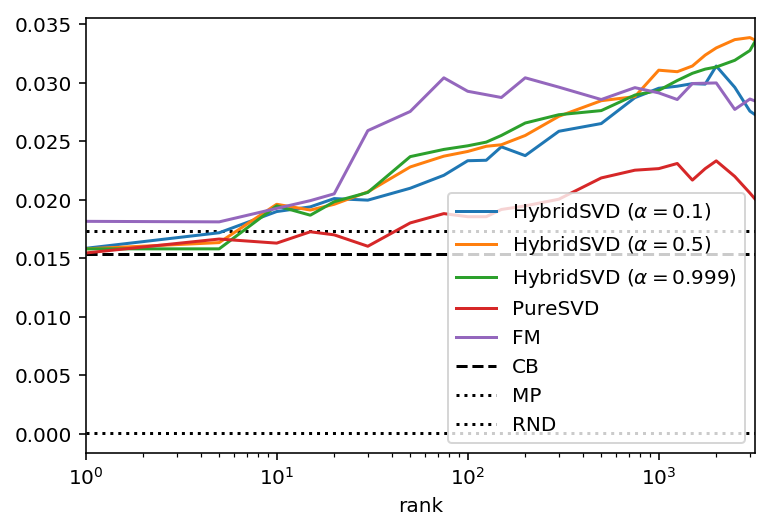

In [165]:
ax = rank_cv_results.xs('HR', 1, 1).mean(level='rank').plot()
fm_results.xs('HR', 1).mean(level=1).plot(ax=ax, label='FM')

linestyles = {'CB': '--', 'RND': ':', 'MP': ':'}
colors = {'CB': '', 'RND': '', 'MP': ''}

for col, data in base_cv_results.xs('HR', 1, 1).mean(level='rank').iteritems():
    ax.hlines(y=data, xmin=1, xmax=3200, label=col, linestyles=linestyles[col])
ax.legend()

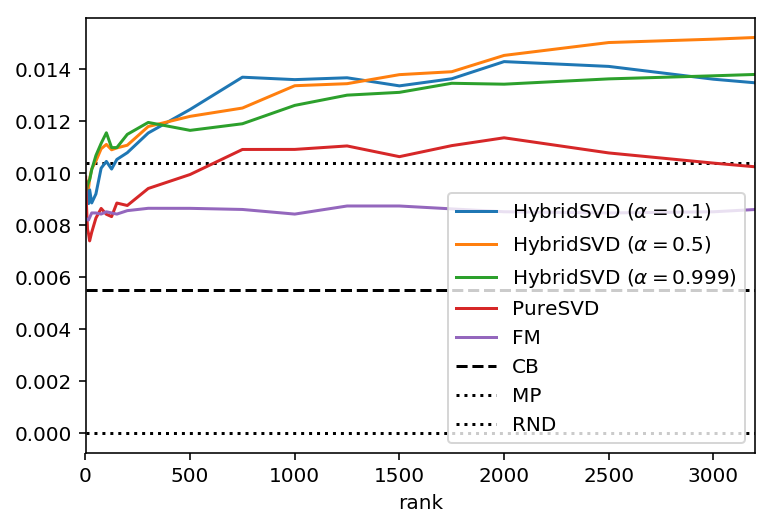

In [304]:
metric = 'MRR'
ax = rank_cv_results.xs(metric, 1, 1).mean(level='rank').plot(logx=False)

fm_results.xs(metric, 1).mean(level=1).plot(ax=ax, label='FM')

linestyles = {'CB': '--', 'RND': ':', 'MP': ':'}
colors = {'CB': '', 'RND': '', 'MP': ''}

for col, data in base_cv_results.xs(metric, 1, 1).mean(level='rank').iteritems():
    ax.hlines(y=data, xmin=1, xmax=3200, label=col, linestyles=linestyles[col])
ax.legend()

# FM

In [73]:
# %env OMP_NUM_THREADS=16
from polara.tools.graphlab.glwrapper import GraphlabFactorization
import graphlab as gl

## Parameter search

In [70]:
from sklearn.model_selection import ParameterGrid

In [204]:
def run_parameter_search(model, data_model, metrics, params_grid, search_space_size=None, verbose=False, seed=None):
    grid_results = {}
    
    data_model.verbose = verbose
    data_model.update()
    eval_func = evaluator(data_model.test.evalset, 'userid', 'isbn')
    
    if search_space_size:
        random_state = np.random.RandomState(seed) if seed else np.random
        param_choice = random_state.choice(len(params_grid), search_space_size, replace=False)
    else:
        param_choice = range(len(params_grid))

    for p in tqdm_notebook(param_choice, desc='params'):
        param_set = params_grid[p]
        build_models([model], config=[param_set], verbose=verbose)

        key = tuple([(''.join([s[0] for s in p.split('_')]), v) for p, v in param_set.iteritems()])
        grid_results[key] = eval_func(model, metrics)
    return grid_results

In [71]:
seed = 42
n_experiments = 120
metrics = 'HR MRR COV'.split()

### Exploration

In [72]:
params = {
          'ranking_regularization': [0.001, 0.003, 0.01, 0.03, 0.1, 0.3],
          'regularization':         [1e-10, 3e-10, 1e-9, 3e-9, 1e-8, 3e-8, 1e-7, 3e-7, 1e-6, 3e-6],
          'linear_regularization':  [1e-10, 3e-10, 1e-9, 3e-9, 1e-8, 3e-8, 1e-7, 3e-7, 1e-6, 3e-6],
          'sgd_step_size':          [0.01, 0.03, 0.01, 0.03, 0.1, 0.3],
          'num_sampled_negative_examples': [None, 1, 5, 10, 15, 20, 30, 50, 70, 100],
          'max_iterations': [40],
          'rank': [1, 5, 10, 20, 30, 50, 75, 100, 150, 200, 250]
         }

params_grid = ParameterGrid(params)
len(params_grid)

396000

In [86]:
# base FM settings
fm = GraphlabFactorization(data_model, item_side_info=books[sim_type.keys()])
fm.method = 'FM'
fm.binary_target = True
fm.solver = 'sgd'
fm.ranking_optimization = True
fm.verbose = False
fm.seed = seed

In [125]:
grid_results = run_parameter_search(fm, data_model, metrics, params_grid, n_experiments, verbose=False, seed=seed)

A Jupyter Widget

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

In [ ]:
grid_results_df = pd.DataFrame.from_dict(grid_results, orient='index')

In [217]:
grid_results_df.to_csv('Random_Search_results_BX.csv', index=True)

In [163]:
grid_results_df.loc[lambda x: x.MRR > 0.8*x.MRR.max()]

HR  \
(sss, 0.1) (r, 1e-07) (rr, 0.01)  (r, 30)  (nsne, 100) (lr, 3e-10) (mi, 40)  0.020516   
           (r, 1e-06) (rr, 0.03)  (r, 100) (nsne, 70)  (lr, 3e-09) (mi, 40)  0.018751   
                      (rr, 0.1)   (r, 20)  (nsne, 100) (lr, 1e-08) (mi, 40)  0.018531   
           (r, 3e-06) (rr, 0.3)   (r, 75)  (nsne, 70)  (lr, 1e-09) (mi, 40)  0.018972   
(sss, 0.3) (r, 3e-10) (rr, 0.001) (r, 50)  (nsne, 30)  (lr, 3e-07) (mi, 40)  0.020737   
           (r, 1e-09) (rr, 0.03)  (r, 150) (nsne, 70)  (lr, 3e-08) (mi, 40)  0.026252   
                      (rr, 0.1)   (r, 75)  (nsne, 20)  (lr, 3e-06) (mi, 40)  0.019193   
           (r, 3e-07) (rr, 0.3)   (r, 200) (nsne, 20)  (lr, 1e-06) (mi, 40)  0.020737   

                                                                                  MRR  \
(sss, 0.1) (r, 1e-07) (rr, 0.01)  (r, 30)  (nsne, 100) (lr, 3e-10) (mi, 40)  0.009130   
           (r, 1e-06) (rr, 0.03)  (r, 100) (nsne, 70)  (lr, 3e-09) (mi, 40)  0.008617   
                      (rr, 0.1)   (r, 20)  (nsne, 100) (lr, 1e-08) (mi, 40)  0.008609   
           (r, 3e-06) (rr, 0.3)   (r, 75)  (nsne, 70)  (lr, 1e-09) (mi, 40)  0.008742   
(sss, 0.3) (r, 3e-10) (rr, 0.001) (r, 50)  (nsne, 30)  (lr, 3e-07) (mi, 40)  0.008909   
           (r, 1e-09) (rr, 0.03)  (r, 150) (nsne, 70)  (lr, 3e-08) (mi, 40)  0.010627   
                      (rr, 0.1)   (r, 75)  (nsne, 20)  (lr, 3e-06) (mi, 40)  0.008610   
           (r, 3e-07) (rr, 0.3)   (r, 200) (nsne, 20)  (lr, 1e-06) (mi, 40)  0.008903   

                                                                              COV  
(sss, 0.1) (r, 1e-07) (rr, 0.01)  (r, 30)  (nsne, 100) (lr, 3e-10) (mi, 40)  1694  
           (r, 1e-06) (rr, 0.03)  (r, 100) (nsne, 70)  (lr, 3e-09) (mi, 40)   890  
                      (rr, 0.1)   (r, 20)  (nsne, 100) (lr, 1e-08) (mi, 40)  1503  
           (r, 3e-06) (rr, 0.3)   (r, 75)  (nsne, 70)  (lr, 1e-09) (mi, 40)   799  
(sss, 0.3) (r, 3e-10) (rr, 0.001) (r, 50)  (nsne, 30)  (lr, 3e-07) (mi, 40)  1227  
           (r, 1e-09) (rr, 0.03)  (r, 150) (nsne, 70)  (lr, 3e-08) (mi, 40)  2173  
                      (rr, 0.1)   (r, 75)  (nsne, 20)  (lr, 3e-06) (mi, 40)  1206  
           (r, 3e-07) (rr, 0.3)   (r, 200) (nsne, 20)  (lr, 1e-06) (mi, 40)  1429

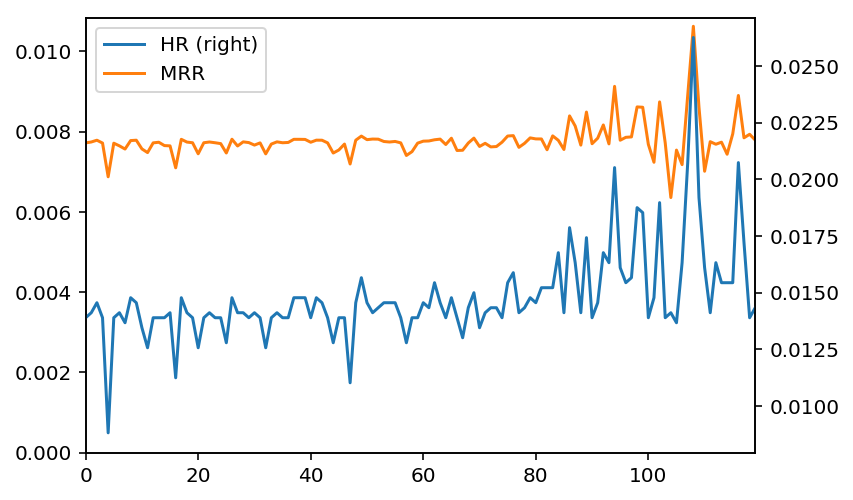

In [200]:
grid_results_df[['HR', 'MRR']].reset_index(drop=True).plot(secondary_y='HR', ylim=(0, None))

In [580]:
grid_results_df.loc[lambda x: x.MRR == x.MRR.max()]

,,,,,,,HR,MRR,COV
"(sss, 0.3)","(r, 1e-09)","(rr, 0.03)","(r, 150)","(nsne, 70)","(lr, 3e-08)","(mi, 40)",0.026252,0.010627,2173


### Fine-tuning

In [169]:
refined_params = {
          'ranking_regularization': [0.01, 0.03, 0.1],
          'regularization':         [3e-10, 1e-9, 3e-9],
          'linear_regularization':  [1e-8, 3e-8, 1e-7],
          'sgd_step_size':          [0.3],
          'num_sampled_negative_examples': [60, 70, 80],
          'max_iterations': [40],
          'rank': [150]
         }
refined_params_grid = ParameterGrid(refined_params)
len(refined_params_grid)

81

In [170]:
grid_results_refined = run_parameter_search(fm, data_model, metrics, refined_params_grid, verbose=False, seed=seed)

A Jupyter Widget

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

In [176]:
grid_results_refined_df = pd.DataFrame.from_dict(grid_results_refined, orient='index')
grid_results_refined_df.loc[lambda x: x.MRR > 0.95*x.MRR.max()]

HR  \
(sss, 0.3) (r, 3e-10) (rr, 0.01) (r, 150) (nsne, 80) (lr, 1e-08) (mi, 40)  0.024928   
                      (rr, 0.03) (r, 150) (nsne, 70) (lr, 3e-08) (mi, 40)  0.025811   
                                          (nsne, 80) (lr, 1e-08) (mi, 40)  0.024487   
                                                     (lr, 1e-07) (mi, 40)  0.025811   
                      (rr, 0.1)  (r, 150) (nsne, 80) (lr, 1e-08) (mi, 40)  0.026031   
           (r, 1e-09) (rr, 0.03) (r, 150) (nsne, 70) (lr, 1e-07) (mi, 40)  0.026473   
                                          (nsne, 80) (lr, 1e-08) (mi, 40)  0.024708   
           (r, 3e-09) (rr, 0.03) (r, 150) (nsne, 60) (lr, 1e-08) (mi, 40)  0.024487   
                      (rr, 0.1)  (r, 150) (nsne, 80) (lr, 3e-08) (mi, 40)  0.023825   

                                                                                MRR  \
(sss, 0.3) (r, 3e-10) (rr, 0.01) (r, 150) (nsne, 80) (lr, 1e-08) (mi, 40)  0.010874   
                      (rr, 0.03) (r, 150) (nsne, 70) (lr, 3e-08) (mi, 40)  0.010978   
                                          (nsne, 80) (lr, 1e-08) (mi, 40)  0.010652   
                                                     (lr, 1e-07) (mi, 40)  0.010642   
                      (rr, 0.1)  (r, 150) (nsne, 80) (lr, 1e-08) (mi, 40)  0.010561   
           (r, 1e-09) (rr, 0.03) (r, 150) (nsne, 70) (lr, 1e-07) (mi, 40)  0.010656   
                                          (nsne, 80) (lr, 1e-08) (mi, 40)  0.011099   
           (r, 3e-09) (rr, 0.03) (r, 150) (nsne, 60) (lr, 1e-08) (mi, 40)  0.010573   
                      (rr, 0.1)  (r, 150) (nsne, 80) (lr, 3e-08) (mi, 40)  0.010994   

                                                                            COV  
(sss, 0.3) (r, 3e-10) (rr, 0.01) (r, 150) (nsne, 80) (lr, 1e-08) (mi, 40)  2272  
                      (rr, 0.03) (r, 150) (nsne, 70) (lr, 3e-08) (mi, 40)  2089  
                                          (nsne, 80) (lr, 1e-08) (mi, 40)  2281  
                                                     (lr, 1e-07) (mi, 40)  2144  
                      (rr, 0.1)  (r, 150) (nsne, 80) (lr, 1e-08) (mi, 40)  2208  
           (r, 1e-09) (rr, 0.03) (r, 150) (nsne, 70) (lr, 1e-07) (mi, 40)  1990  
                                          (nsne, 80) (lr, 1e-08) (mi, 40)  2260  
           (r, 3e-09) (rr, 0.03) (r, 150) (nsne, 60) (lr, 1e-08) (mi, 40)  1873  
                      (rr, 0.1)  (r, 150) (nsne, 80) (lr, 3e-08) (mi, 40)  2122

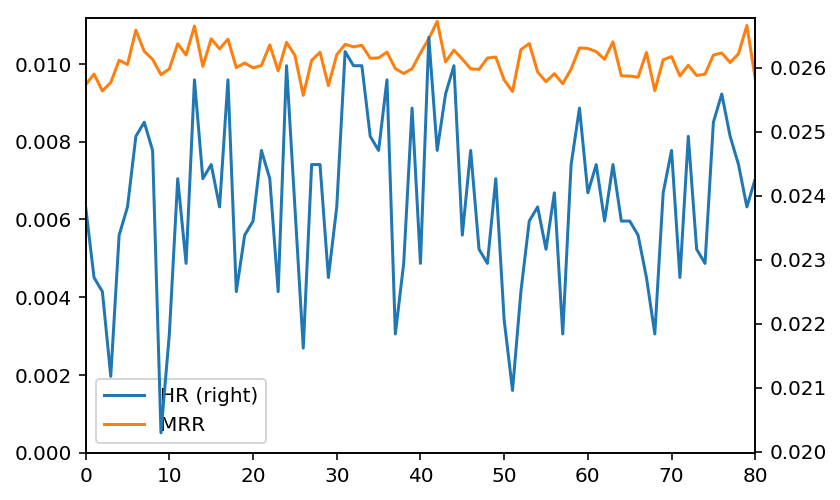

In [199]:
grid_results_refined_df[['HR', 'MRR']].reset_index(drop=True).plot(secondary_y='HR', ylim=(0, None))

In [178]:
grid_results_refined_df.loc[lambda x: (x.MRR == x.MRR.max()) | (x.HR == x.HR.max())]

HR  \
(sss, 0.3) (r, 1e-09) (rr, 0.03) (r, 150) (nsne, 70) (lr, 1e-07) (mi, 40)  0.026473   
                                          (nsne, 80) (lr, 1e-08) (mi, 40)  0.024708   

                                                                                MRR  \
(sss, 0.3) (r, 1e-09) (rr, 0.03) (r, 150) (nsne, 70) (lr, 1e-07) (mi, 40)  0.010656   
                                          (nsne, 80) (lr, 1e-08) (mi, 40)  0.011099   

                                                                            COV  
(sss, 0.3) (r, 1e-09) (rr, 0.03) (r, 150) (nsne, 70) (lr, 1e-07) (mi, 40)  1990  
                                          (nsne, 80) (lr, 1e-08) (mi, 40)  2260

### Final

In [283]:
final_params = {
          'ranking_regularization': 0.03,
          'regularization':         1e-9,
          'linear_regularization':  1e-8,
          'sgd_step_size':          0.3,
          'num_sampled_negative_examples': 80,
          'max_iterations': 70, # increased for better results
          'rank': 150,
         }

In [284]:
final_res = run_parameter_search(fm, data_model, metrics, [final_params], verbose=True, seed=seed)

A Jupyter Widget

Recsys training: model = ranking_factorization_recommender

Preparing data set.

Data has 501039 observations with 45575 users and 89904 items.

Data prepared in: 0.585034s

Training ranking_factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 150      |

| regularization                 | L2 Regularization on Factors                     | 1e-09    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-08    |

| ranking_regularization         | Rank-based Regularization Weight                 | 0.03     |

| num_sampled_negative_examples  | # Negative Samples Considered per Observation    | 80       |

| binary_target                  | Assume Binary Targets                            | True     |

| side_data_factorization        | Assign Factors for Side Data                     | True     |

| sgd_step_size                  | Starting SGD Step Size                           | 0.3      |

| max_iterations                 | Maximum Number of Iterations                     | 70       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD (step size tuning: OFF).

Starting Optimization.

+---------+--------------+-------------------+-----------------------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training Predictive Error | Step Size   |

+---------+--------------+-------------------+-----------------------------------+-------------+

| Initial | 911us        | 1.62715           | 0.313259                          |             |

+---------+--------------+-------------------+-----------------------------------+-------------+

| 1       | 9.09s        | DIVERGED          | DIVERGED                          | 0.3         |

| RESET   | 13.70s       | 1.62714           | 0.313264                          |             |

| 1       | 18.24s       | 1.33103           | 0.659192                          | 0.15        |

| 2       | 22.80s       | 1.36056           | 0.678976                          | 0.0891905   |

| 3       | 27.41s       | 1.20168           | 0.589964                          | 0.0658037   |

| 4       | 31.98s       | 1.40973           | 0.689306                          | 0.0445953   |

| 5       | 36.50s       | 1.38794           | 0.690139                          | 0.0317211   |

| 6       | 41.16s       | 1.40426           | 0.70096                           | 0.0232651   |

| 7       | 45.74s       | 1.38655           | 0.694676                          | 0.0174276   |

| 8       | 50.24s       | 1.37485           | 0.689262                          | 0.0132583   |

| 9       | 54.79s       | 1.36486           | 0.684412                          | 0.0102062   |

| 10      | 59.34s       | 1.353             | 0.67878                           | 0.00943075  |

| 11      | 1m 3s        | 1.34261           | 0.673708                          | 0.00878015  |

| 12      | 1m 8s        | 1.3337            | 0.669387                          | 0.00822546  |

| 13      | 1m 12s       | 1.32487           | 0.664803                          | 0.0077462   |

| 14      | 1m 17s       | 1.31647           | 0.660668                          | 0.00732741  |

| 15      | 1m 22s       | 1.30855           | 0.656818                          | 0.00695789  |

| 16      | 1m 26s       | 1.30069           | 0.653195                          | 0.00662913  |

| 17      | 1m 31s       | 1.29266           | 0.649049                          | 0.00633446  |

| 18      | 1m 35s       | 1.28541           | 0.64545                           | 0.00606865  |

| 19      | 1m 40s       | 1.27805           | 0.641964                          | 0.00582748  |

| 20      | 1m 44s       | 1.27087           | 0.63838                           | 0.00560756  |

| 21      | 1m 49s       | 1.26397           | 0.635166                          | 0.00540607  |

| 22      | 1m 54s       | 1.25718           | 0.631553                          | 0.00522071  |

| 23      | 1m 58s       | 1.2507            | 0.628323                          | 0.00504952  |

| 24      | 2m 3s        | 1.24461           | 0.625431                          | 0.00489089  |

| 25      | 2m 8s        | 1.23817           | 0.622306                          | 0.00474342  |

| 26      | 2m 12s       | 1.23232           | 0.619255                          | 0.00460592  |

| 27      | 2m 17s       | 1.22681           | 0.616797                          | 0.00447737  |

| 28      | 2m 22s       | 1.22072           | 0.613638                          | 0.0043569   |

| 29      | 2m 26s       | 1.21543           | 0.611111                          | 0.00424373  |

| 30      | 2m 31s       | 1.21004           | 0.608656                          | 0.00413719  |

| 31      | 2m 36s       | 1.20441           | 0.605709                          | 0.00403669  |

| 32      | 2m 40s       | 1.19981           | 0.603419                          | 0.0039417   |

| 33      | 2m 45s       | 1.19445           | 0.60044                           | 0.00385177  |

| 34      | 2m 49s       | 1.18973           | 0.598378                          | 0.00376649  |

| 35      | 2m 54s       | 1.185             | 0.596011                          | 0.00368549  |

| 36      | 2m 59s       | 1.18077           | 0.593837                          | 0.00360844  |

| 37      | 3m 3s        | 1.17604           | 0.591439                          | 0.00353505  |

| 38      | 3m 8s        | 1.17168           | 0.589372                          | 0.00346504  |

| 39      | 3m 13s       | 1.16721           | 0.587146                          | 0.00339819  |

| 40      | 3m 17s       | 1.16302           | 0.584787                          | 0.00333427  |

| 41      | 3m 22s       | 1.15915           | 0.583286                          | 0.00327309  |

| 42      | 3m 27s       | 1.15484           | 0.581088                          | 0.00321447  |

| 43      | 3m 31s       | 1.15093           | 0.579235                          | 0.00315824  |

| 44      | 3m 36s       | 1.14734           | 0.576946                          | 0.00310425  |

| 45      | 3m 41s       | 1.1437            | 0.575534                          | 0.00305237  |

| 46      | 3m 45s       | 1.13996           | 0.573551                          | 0.00300246  |

| 47      | 3m 50s       | 1.1365            | 0.571843                          | 0.00295442  |

| 48      | 3m 55s       | 1.13288           | 0.570203                          | 0.00290814  |

| 49      | 3m 59s       | 1.12902           | 0.568371                          | 0.00286351  |

| 50      | 4m 4s        | 1.12598           | 0.566862                          | 0.00282045  |

| 51      | 4m 9s        | 1.12265           | 0.565365                          | 0.00277887  |

| 52      | 4m 13s       | 1.11949           | 0.563437                          | 0.0027387   |

| 53      | 4m 18s       | 1.11611           | 0.561634                          | 0.00269985  |

| 54      | 4m 23s       | 1.11305           | 0.560297                          | 0.00266226  |

| 55      | 4m 27s       | 1.11032           | 0.558911                          | 0.00262588  |

| 56      | 4m 32s       | 1.10687           | 0.557405                          | 0.00259063  |

| 57      | 4m 37s       | 1.10417           | 0.555946                          | 0.00255647  |

| 58      | 4m 41s       | 1.10124           | 0.554366                          | 0.00252334  |

| 59      | 4m 46s       | 1.09849           | 0.552935                          | 0.00249119  |

| 60      | 4m 50s       | 1.09539           | 0.551366                          | 0.00245999  |

| 61      | 4m 55s       | 1.09255           | 0.550127                          | 0.00242968  |

| 62      | 5m 0s        | 1.08993           | 0.548851                          | 0.00240023  |

| 63      | 5m 4s        | 1.08746           | 0.547244                          | 0.0023716   |

| 64      | 5m 9s        | 1.08457           | 0.546084                          | 0.00234375  |

| 65      | 5m 14s       | 1.08211           | 0.544963                          | 0.00231665  |

| 66      | 5m 18s       | 1.07967           | 0.543768                          | 0.00229028  |

| 67      | 5m 23s       | 1.07699           | 0.542657                          | 0.00226459  |

| 68      | 5m 28s       | 1.07446           | 0.540952                          | 0.00223957  |

| 69      | 5m 32s       | 1.07214           | 0.539903                          | 0.00221518  |

| 70      | 5m 37s       | 1.0698            | 0.538705                          | 0.00219141  |

+---------+--------------+-------------------+-----------------------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training Predictive Error.

Final objective value: 1.06901

Final training Predictive Error: 0.536468

FM training time: 347.336374s


recommendations finished on 1000/4533 queries. users per second: 281.379

recommendations finished on 2000/4533 queries. users per second: 280.478

recommendations finished on 3000/4533 queries. users per second: 281.695

recommendations finished on 4000/4533 queries. users per second: 282.784

recommendations finished on 1000/4533 queries. users per second: 278.905

recommendations finished on 2000/4533 queries. users per second: 283.638

recommendations finished on 3000/4533 queries. users per second: 285.993

recommendations finished on 4000/4533 queries. users per second: 287.402

In [285]:
final_res

{(('sss', 0.3),
  ('r', 1e-09),
  ('rr', 0.03),
  ('r', 150),
  ('nsne', 80),
  ('lr', 1e-08),
  ('mi', 70)): {'COV': 2689,
  'HR': 0.028899183763512023,
  'MRR': 0.011830614295869093}}

Saving best config

In [286]:
pd.Series(dict(binary_target = True,
               solver = 'sgd',
               ranking_optimization = True,
               verbose = False,
               seed = seed,
               name = 'FM',
               **final_params)).to_csv('FM_BX_standard_best_config.csv')

## Cross-validation

In [295]:
metrics = 'HR MRR COV'.split()
ranks = [1, 5, 10, 15, 20, 30, 50, 75, 100, 125, 150, 200, 300, 500, 750, 1000, 1500, 2000, 3200]

fm_cv_results = rank_cv_experiment([fm], data_model, metrics, ranks=ranks, verbose=False)

A Jupyter Widget

Data is ready. No action was taken.


Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

In [296]:
fm_rank_cv_results = get_results_dataframe(fm_cv_results, params=ranks, names='rank')

In [297]:
fm_rank_cv_results.to_csv('Standard_FM_CV_results_BX.csv')

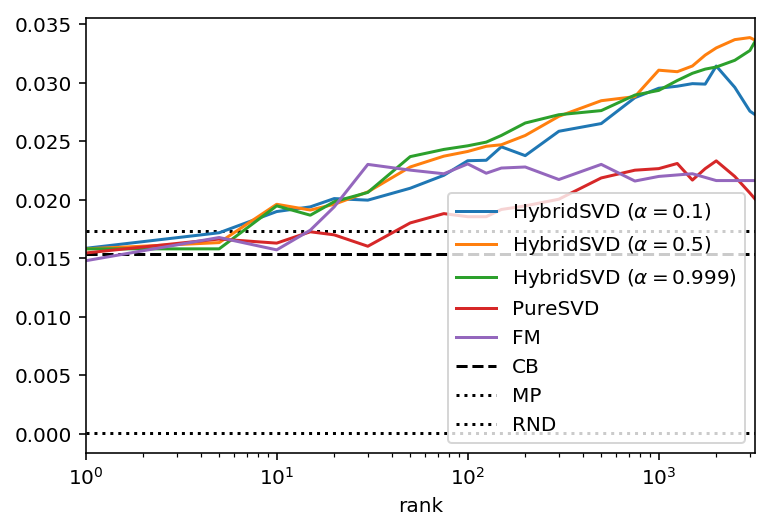

In [306]:
metric = 'HR'
ax = rank_cv_results.xs(metric, 1, 1).mean(level='rank').plot(logx=True)

fm_rank_cv_results.xs(metric, 1, 1).mean(level=1).plot(ax=ax, label='FM')

linestyles = {'CB': '--', 'RND': ':', 'MP': ':'}
colors = {'CB': '', 'RND': '', 'MP': ''}

for col, data in base_cv_results.xs(metric, 1, 1).mean(level='rank').iteritems():
    ax.hlines(y=data, xmin=1, xmax=3200, label=col, linestyles=linestyles[col])
ax.legend()

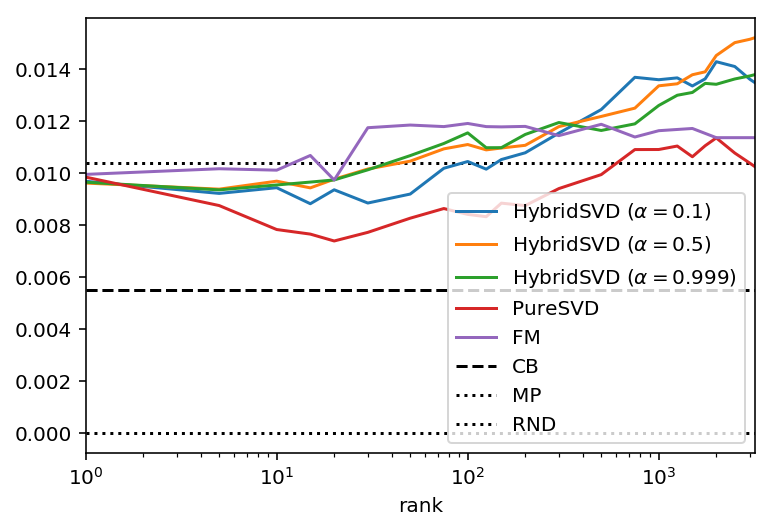

In [305]:
metric = 'MRR'
ax = rank_cv_results.xs(metric, 1, 1).mean(level='rank').plot(logx=True)

fm_rank_cv_results.xs(metric, 1, 1).mean(level=1).plot(ax=ax, label='FM')

linestyles = {'CB': '--', 'RND': ':', 'MP': ':'}
colors = {'CB': '', 'RND': '', 'MP': ''}

for col, data in base_cv_results.xs(metric, 1, 1).mean(level='rank').iteritems():
    ax.hlines(y=data, xmin=1, xmax=3200, label=col, linestyles=linestyles[col])
ax.legend()

In [386]:
rank_cv_results.loc[:, ('PureSVD', 'MRR')].mean(level='rank').loc[lambda x: x == x.max()]

rank
2000    0.011359
Name: (PureSVD, MRR), dtype: float64

In [387]:
fm_rank_cv_results.loc[:, ('FM', 'MRR')].mean(level='rank').loc[lambda x: x == x.max()]

rank
100    0.011914
Name: (FM, MRR), dtype: float64

# Top-N recommendtions

In [309]:
def topk_evaluator(test_data, key, target):
    def eval_func(model, metrics):
        scores = {}
        
        topk = model.topk
        recommendations = model.recommendations
        assert recommendations.shape[-1] >= topk
        
        hits = evaluate_hits(test_data, key, target, recommendations[..., :topk])
        if 'HR' in metrics:
            # calculate hit rate
            hit_rate = hits.getnnz(axis=1).mean()
            scores['HR'] = hit_rate
        if 'MRR' in metrics:
            # calculate hit reciprocal rank
            hits.data = 1. / hits.data
            scores['MRR'] = hits.max(axis=1).mean()
        if 'COV' in metrics:
            # assortment coverage
            scores['COV'] = np.unique(model.recommendations).size
        return scores
    return eval_func

def set_models_topk(models, topk):
    for model in models:
        setattr(model, 'topk', topk)

def topk_evaluate_models(models, eval_func, metrics, topk):
    set_models_topk(models, topk)
    return evaluate_models(models, eval_func, metrics)

In [310]:
def topk_cv_experiment(models, data_model, metrics, topk_list=[10], models_configuration=None, no_attr='raise', verbose=False, folds=None):
    cv_results = defaultdict(lambda: defaultdict(dict))
    folds = folds or range(1, int(1 / data_model.test_ratio)+1)
    
    topk_list = list(reversed(sorted(topk_list))) # start from max value, avoids rebuilding models
    data_model.verbose = verbose
    
    for fold in tqdm_notebook(folds, desc='fold'):
        data_model.test_fold = fold
        data_model.prepare()
        
        eval_func = topk_evaluator(data_model.test.evalset, 'userid', 'isbn')
        
        set_models_topk(models, max(topk_list))
        build_models(models, config=models_configuration, verbose=verbose)
                
        for topk in topk_list:
            scores = topk_evaluate_models(models, eval_func, metrics, topk)            
            cv_results[fold][topk] = scores

    return cv_results

In [331]:
psvd.rank = 2000
fm.rank = 100

hsvd = [hybrid_svd for hybrid_svd in hybrids if '0.5' in hybrid_svd.method][0]
hsvd.rank = 3200

In [332]:
topk_models = baselines + [psvd, fm, hsvd]

for model in topk_models:
    print model.method,

MP RND CB PureSVD FM HybridSVD ($\alpha=0.5$)


In [ ]:
topk_list = [1, 3, 10, 20, 30]

topk_cv_results = topk_cv_experiment(topk_models, data_model, metrics, topk_list=topk_list, no_attr='raise', verbose=False)

A Jupyter Widget

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

In [ ]:
topk_cv_results_df = get_results_dataframe(topk_cv_results, params=topk_list, names='topk')

In [355]:
topk_cv_results_df.to_csv('Standard_TopN_CV_results_BX.csv')

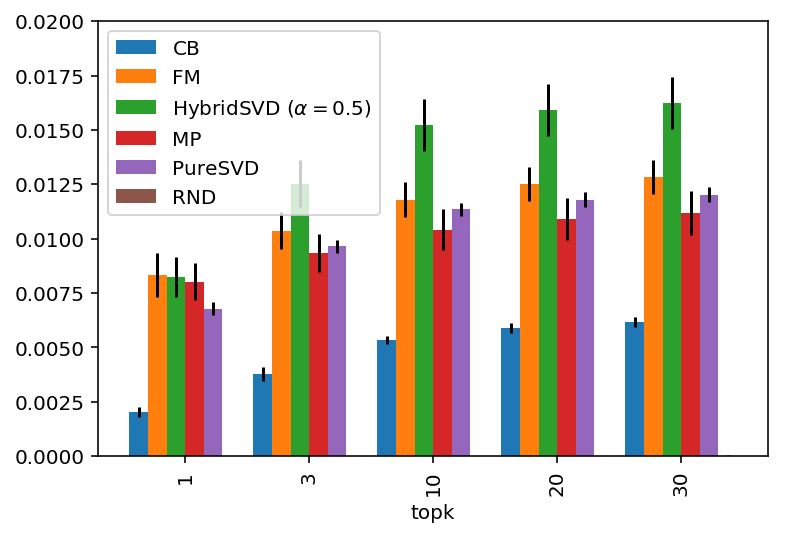

In [354]:
topk_cv_results_df.xs('MRR', 1, 1).mean(level='topk').plot.bar(yerr=sample_ci(topk_cv_results_df.xs('MRR', 1, 1), level='topk'), width=0.9, logy=False, ylim=(0, 0.02))

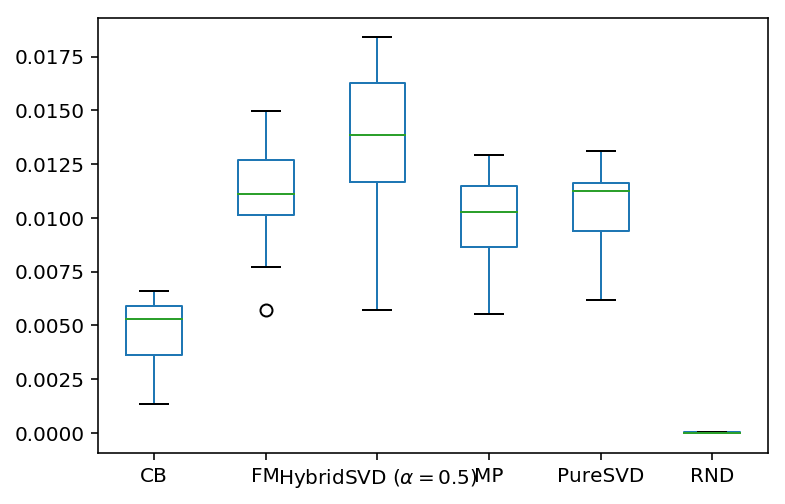

In [474]:
topk_cv_results_df.xs('MRR', 1, 1).plot.box(by='rank')
# topk_cv_results_df.xs('MRR', 1, 1).xs(20, 0, 1).plot.box(ax=ax, positions=[2, 4, 6, 8, 10, 12])
# ax.set_xlim(-1, 13)

In [401]:
topk_cv_results_df.xs('MRR', 1, 1).xs(10, 0, 1).T#.plot.box(return_type='axes')

fold,1,2,3,4,5
CB,0.005633,0.005526,0.005024,0.005597,0.004903
FM,0.011805,0.010113,0.014015,0.012067,0.011002
HybridSVD ($\alpha=0.5$),0.017447,0.012505,0.013826,0.015068,0.017257
MP,0.011501,0.009980,0.012091,0.010716,0.007723
PureSVD,0.012249,0.011234,0.011394,0.011024,0.010867
RND,0.000000,0.000032,0.000000,0.000000,0.000022


(-1, 5)

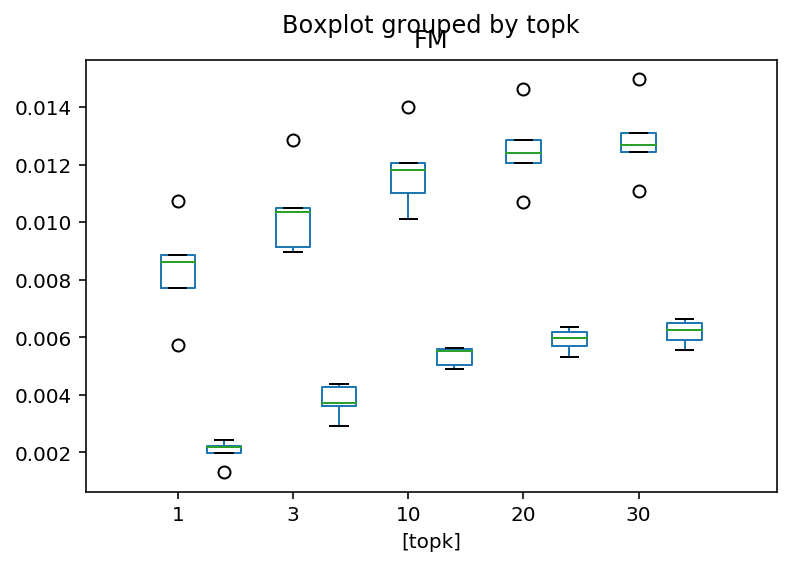

In [579]:
ax = topk_cv_results_df.xs(('MRR'), 1, 1)[['CB']].boxplot(by='topk', grid=False, positions=np.arange(len(topk_list))+0.2, widths=0.3)#, patch_artist=True, manage_xticks=False)
topk_cv_results_df.xs(('MRR'), 1, 1)[['FM']].boxplot(by='topk', grid=False, positions=np.arange(len(topk_list))-0.2, widths=0.3, ax=ax)#, patch_artist=True, manage_xticks=False)
ax.set_xlim(-1, 5)

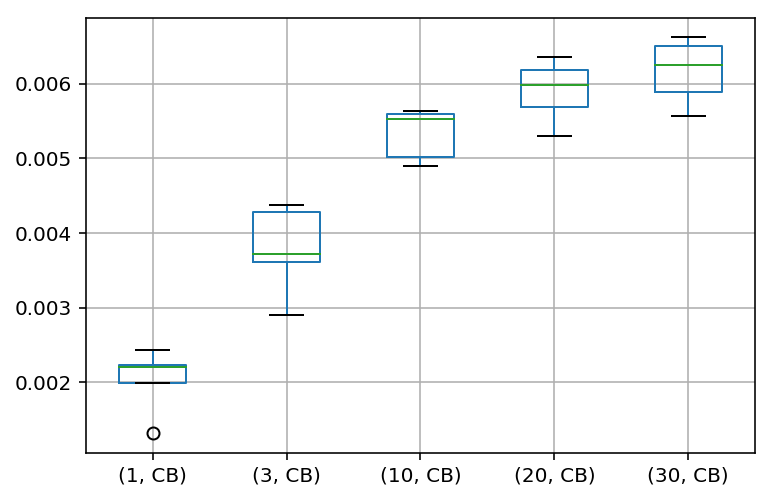

In [526]:
topk_cv_results_df.xs(('MRR'), 1, 1)[['CB']].groupby('topk').boxplot(subplots=False, positions=[1, 2, 3, 4, 5])